In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-06-11'
end_day_to_analyze = '2020-06-12'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,4114,1474,BZQ,buy,188,17.82,"{'avg': 17.1311, 'rsi': 67.99532792944044, 'ma...",2020-06-11 16:28:11.179044+00:00,2020-06-11 16:28:13.541000,17.29,18.88
1,4148,1475,BZQ,buy,188,17.82,"{'avg': 17.1311, 'rsi': 67.99532792944044, 'ma...",1474,2020-06-11 17:48:52.676944,17.29,18.88
2,4176,1475,BZQ,sell,145,18.04,"{'avg': 17.3806, 'rsi': [77.34487505985891, 79...",2020-06-11 18:58:42.326196+00:00,2020-06-11 18:58:43.033791,17.29,18.88
3,4177,1475,BZQ,sell,43,18.04,"{'avg': 17.3806, 'rsi': [77.34487505985891, 79...",2020-06-11 18:58:42.700936+00:00,2020-06-11 18:58:43.270481,17.29,18.88
4,4135,1474,CHK,buy,199,18.70,"{'avg': 18.6052, 'rsi': 58.12319808103354, 'ma...",2020-06-11 17:16:49.135778+00:00,2020-06-11 17:16:49.471567,18.20,19.70
...,...,...,...,...,...,...,...,...,...,...,...
87,4104,1465,THMO,buy,364,6.37,"{'avg': 6.233, 'rsi': 65.65705484441536, 'macd...",2020-06-11 14:44:13.303010+00:00,2020-06-11 14:44:46.264828,6.10,6.92
88,4105,1466,THMO,buy,364,6.37,"{'avg': 6.233, 'rsi': 65.65705484441536, 'macd...",1465,2020-06-11 15:05:28.990320,6.10,6.92
89,4106,1466,THMO,sell,364,6.06,"{'avg': 6.2313, 'rsi': [35.46397151677576, 34....",2020-06-11 15:06:04.652582+00:00,2020-06-11 15:06:05.151711,6.10,6.92
90,4150,1475,UGAZ,buy,454,13.89,"{'avg': 13.5526, 'rsi': 64.22155894481692, 'ma...",2020-06-11 18:05:37.029393+00:00,2020-06-11 18:05:37.500358,13.67,14.33


In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)
algo_runs.set_index('algo_run_id', inplace=True)

In [8]:
algo_runs

,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason,batch_id
algo_run_id,,,,,,,,
1461,momentum_long,PAPER,0.1-493-g164e124,{'DSN': 'postgresql://momentum@localhost/trade...,2020-06-11 01:58:46.820286,None,None,76e00ee6-7fa5-4e8b-a35d-cf558d93807d
1462,momentum_long,PAPER,0.1-493-g164e124,{'DSN': 'postgresql://momentum@localhost/trade...,2020-06-11 01:58:47.500082,None,None,76e00ee6-7fa5-4e8b-a35d-cf558d93807d
1463,momentum_long,PAPER,0.1-493-g164e124,{'DSN': 'postgresql://momentum@localhost/trade...,2020-06-11 01:58:48.196537,None,None,76e00ee6-7fa5-4e8b-a35d-cf558d93807d
1464,momentum_long,PAPER,0.1-493-g164e124,{'DSN': 'postgresql://momentum@localhost/trade...,2020-06-11 01:58:49.640306,None,None,76e00ee6-7fa5-4e8b-a35d-cf558d93807d
1465,momentum_long,PAPER,v0.1-495-g5c142bf,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-11 13:50:20.816538,None,None,ee502a3d-267d-46f9-b562-c215515ee46b
1466,momentum_long,PAPER,v0.1-495-g5c142bf,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-11 15:05:28.391535,None,None,8f58fffb-12ef-4d12-a061-a8f787ffe4bc
1467,momentum_long,PAPER,v0.1-495-g5c142bf,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-11 15:31:47.735187,None,None,db5d4dde-3d57-4730-8ca4-f51950574223
1468,momentum_long,PAPER,v0.1-495-g5c142bf,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-11 15:51:38.745581,None,None,00a18a2e-da19-4de0-8bf9-6bffd371f67f
1469,momentum_long,PAPER,0.1-493-g164e124,{'DSN': 'postgresql://momentum@localhost/trade...,2020-06-11 15:58:05.195184,None,None,d550177a-0709-410b-98f2-ab7e070cd7e7


In [9]:
trade_details = {}
batch = {}
for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    batch_id = algo_runs.loc[algo_run_id]['batch_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))
    if batch_id not in batch:
        batch[batch_id] = []
    if algo_run_id not in batch[batch_id]:
        #print(batch_id, algo_run_id)
        batch[batch_id].append(algo_run_id)

In [10]:
revenues = {}
how_was_my_day = {}

for batch_id, count in batch.items():
    revenues[batch_id] = []
    symbol_name = []
    counts = []
    for run_id in batch[batch_id]:
        
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            revnue = 0
            for trade in trade_details[run_id][symbol]:
                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                revnue += delta

            revenues[batch_id].append(revnue)
            counts.append(count)
            symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[batch_id],
    }
    how_was_my_day[batch_id] = pd.DataFrame(data=d)

In [11]:
for batch_id, how_did_i_do in how_was_my_day.items():
    #display(HTML(algo_runs.loc[algo_runs['batch_id'] == batch_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[batch_id]).sum().round(2)} $ for {batch_id}')


,symbol,count,revenue
3,DXD,2,-4183.91
6,BZQ,1,-3350.16
5,DRV,2,-109.00
4,FAZ,2,-94.86
1,CHK,10,30.27
2,HUYA,7,33.95
0,SOXS,12,42.55


TOTAL REVENUE: -7631.16 $ for af99f0f9-be05-49e3-8d9d-bcced79172fb


,symbol,count,revenue
3,DRV,4,13.27
8,UGAZ,2,18.16
4,BZQ,3,41.36
7,PSQ,2,46.62
0,DXD,15,53.19
1,SRS,14,56.68
6,QID,2,58.32
5,SOXS,3,60.96
2,SQQQ,4,76.34


TOTAL REVENUE: 424.9 $ for 96bd3a4d-7840-4ccd-a971-75bf53ae2805


,symbol,count,revenue
0,DRV,1,-7241.92


TOTAL REVENUE: -7241.92 $ for 0059648d-be2a-4324-82a4-0d46753051cd


,symbol,count,revenue
0,DRV,1,-7241.92


TOTAL REVENUE: -7241.92 $ for a916a409-48e0-4b9d-a9ee-de1da5692a7d


,symbol,count,revenue
0,DRV,2,-38.43


TOTAL REVENUE: -38.43 $ for 05f1ebee-fdec-4dc4-8621-3d6ed797ea69


,symbol,count,revenue
0,THMO,1,-2318.68


TOTAL REVENUE: -2318.68 $ for ee502a3d-267d-46f9-b562-c215515ee46b


,symbol,count,revenue
0,THMO,2,-112.84


TOTAL REVENUE: -112.84 $ for 8f58fffb-12ef-4d12-a061-a8f787ffe4bc


In [12]:
minute_history = {}
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            if symbol not in minute_history:
                minute_history[symbol] = api.polygon.historic_agg_v2(
                    symbol, 
                    1, 
                    'minute',
                    _from = str((datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date()),
                    to=str((datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date())).df


In [13]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4, minutes=1)
    #print(now)
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    #print(minute_history["close"][minute_history_index-10:minute_history_index])
    for back_track_min in range(120, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().between_time("9:30", "16:00").resample("5min").max()
        ).dropna()
        #print(series[-10:])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                #print([i for i in high_index if series[i] >= current_value])
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(120, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

SOXS analysis for run 1474 with profit 42.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3910.68,-3910.68,buy,2020-06-11 16:20:13.551308,6.12,[6.025],[6.22],639,"{'avg': 5.9736, 'rsi': 69.53835931094963, 'macd': [0.011226601709162232, 0.012225437237453285, 0.01438434897913421, 0.015999629130262427, 0.018383114956583846], 'vwap': 6.1264, 'supports': [5.825, 5.945, 5.99, 6.025], 'sell_macd': [0.006479100500605739, 0.007127466547991901, 0.008527135331046765, 0.00956418717068619, 0.011094822537018878], 'slow macd': [0.01577103334593577, 0.015971987447945146, 0.016435205136442477, 0.01685268737582213, 0.017470526593458047], 'macd_signal': [0.01035505930812979, 0.010729134893994489, 0.011460177711022434, 0.012368067994870433, 0.013571077387213115], 'resistances': [6.22], 'position_ratio': '0.92', 'sell_macd_signal': [0.00589687773573404, 0.006142995498185612, 0.006619823464757842, 0.007208696205943511, 0.007985921472158585]}",6.44,5.97
1,-1942.45,1968.23,sell,2020-06-11 16:29:09.390846,6.17,None,None,319,"{'avg': 5.9827, 'rsi': [71.72468184744002, 75.05264560116467], 'vwap': 6.1792, 'reasons': 'scale-out', 'movement': 0.008986928104575118, 'sell_macd': [0.00954622725587484, 0.010075974935614518, 0.011656609816767194, 0.013256369336929197, 0.015369735595016643], 'sell_macd_signal': [0.009212933509141001, 0.009385541794435705, 0.009839755398902004, 0.010523078186507443, 0.011492409668209283]}",6.44,5.97
2,-952.05,990.40,sell,2020-06-11 16:52:29.093413,6.19,None,None,160,"{'avg': 5.9977, 'rsi': [66.23221975072146, 69.62761332149387], 'vwap': 6.1998, 'reasons': 'scale-out', 'movement': 0.004829821717990248, 'sell_macd': [0.007898537781682258, 0.010901185796102553, 0.013099337680118062, 0.01411738671077778, 0.0157610952189442], 'sell_macd_signal': [0.003927710653915423, 0.005322405682352848, 0.006877792081905891, 0.00832571100768027, 0.009812787849933054]}",6.44,5.97
3,-455.25,496.80,sell,2020-06-11 16:54:48.041328,6.21,None,None,80,"{'avg': 6.0003, 'rsi': [69.81765948610116, 71.49426726297634], 'vwap': 6.21, 'reasons': 'scale-out', 'movement': 0.003231017770597669, 'sell_macd': [0.013099337680118062, 0.01411738671077778, 0.01499226405011278, 0.016253307898294267, 0.017549532872224383], 'sell_macd_signal': [0.006877792081905891, 0.00832571100768027, 0.00965902161616677, 0.01097787887259227, 0.012292209672518692]}",6.44,5.97
4,-206.45,248.80,sell,2020-06-11 16:55:04.645159,6.22,None,None,40,"{'avg': 6.0007, 'rsi': [69.81765948610116, 72.98033027304068], 'vwap': 6.22, 'reasons': 'scale-out', 'movement': 0.0016103059581320108, 'sell_macd': [0.013099337680118062, 0.01411738671077778, 0.01499226405011278, 0.016253307898294267, 0.018069013391704303], 'sell_macd_signal': [0.006877792081905891, 0.00832571100768027, 0.00965902161616677, 0.01097787887259227, 0.012396105776414677]}",6.44,5.97
5,-81.85,124.60,sell,2020-06-11 16:55:12.495736,6.23,None,None,20,"{'avg': 6.0007, 'rsi': [72.98033027304068, 74.4166374293806], 'vwap': 6.23, 'reasons': 'scale-out', 'movement': 0.0016077170418007517, 'sell_macd': [0.01411738671077778, 0.01499226405011278, 0.016253307898294267, 0.018069013391704303, 0.019768666849015126], 'sell_macd_signal': [0.00832571100768027, 0.00965902161616677, 0.01097787887259227, 0.012396105776414677, 0.013870617990934767]}",6.44,5.97
6,-19.65,62.20,sell,2020-06-11 16:58:43.049378,6.22,None,None,10,"{'avg': 6.0042, 'rsi': [64.62655557823601, 69.82394067273093], 'vwap': 6.229, 'reasons': 'scale-out', 'movement': -0.00016051364365976466, 'sell_macd': [0.018069013391704303, 0.018729705810054398, 0.01821687255409188, 0.017845614529262477, 0.01883105484070402], 'sell_macd_signal': [0.012396105776414677, 0.01366282578314262, 0.014573635137332471, 0.015228031015718473, 0.01594863578071558]}",6.44,5.97
7,11.45,31.10,sell,2020-06-11 16:58:44.082435,6.22,None,None,5,"{'avg': 6.0043, 'rsi': [64.62655557823601, 68.94276945898955], 'vwap': 6.2234, 'reasons': 'scale-out', 'movement': 0.0005466237942122298, 'sell_macd': [0.018069013391704303, 0

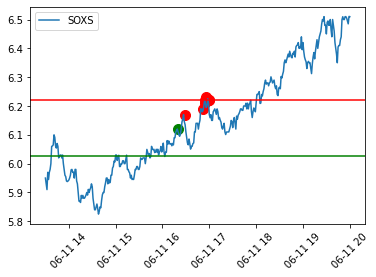

CHK analysis for run 1474 with profit 30.27


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3721.30,-3721.30,buy,2020-06-11 17:16:49.471567,18.70,"[17.0201, 18.08, 18.1681, 18.2601]",[18.8],199,"{'avg': 18.6052, 'rsi': 58.12319808103354, 'macd': [0.0279240976176105, 0.026977992226672853, 0.03649910062720352, 0.047244138825597304, 0.061505987683876384], 'vwap': 18.6891, 'supports': [17.02, 18.08, 18.1681, 18.2601, 18.5246, 18.605], 'sell_macd': [0.01624295724152347, 0.015593533377426638, 0.021768092270633588, 0.028707123976108306, 0.03789718603263381], 'slow macd': [-0.009231181109413455, -0.00803266780173928, -0.0047979977528953555, -0.001072220954252856, 0.003636815949985106], 'macd_signal': [0.02873363531682, 0.028382506698790572, 0.030005825484473163, 0.03345348815269799, 0.03906398805893367], 'resistances': [18.8, 19.1601, 19.38, 19.7], 'position_ratio': '1.05', 'sell_macd_signal': [0.01711231557927953, 0.01680855913890895, 0.01780046576525388, 0.019981797407424763, 0.02356487513246657]}",19.7,18.2
1,-1857.13,1864.17,sell,2020-06-11 17:21:46.054926,18.83,None,None,99,"{'avg': 18.6057, 'rsi': [59.21103113537001, 60.750763099680036], 'vwap': 18.8, 'reasons': 'scale-out', 'movement': 0.0053475935828877766, 'sell_macd': [0.034245237980687904, 0.039689934114377934, 0.04944307481446941, 0.05490646919356834, 0.06119167949944426], 'sell_macd_signal': [0.02283448552207739, 0.026205575240537498, 0.03085307515532388, 0.03566375396297277, 0.04076933907026707]}",19.7,18.2
2,-915.63,941.50,sell,2020-06-11 17:21:50.934122,18.83,None,None,50,"{'avg': 18.6059, 'rsi': [59.21103113537001, 61.57542987575005], 'vwap': 18.8452, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.034245237980687904, 0.039689934114377934, 0.04944307481446941, 0.05490646919356834, 0.06275012105788491], 'sell_macd_signal': [0.02283448552207739, 0.026205575240537498, 0.03085307515532388, 0.03566375396297277, 0.041081027381955196]}",19.7,18.2
3,-443.13,472.50,sell,2020-06-11 17:21:55.960583,18.90,None,None,25,"{'avg': 18.606, 'rsi': [59.21103113537001, 62.660705942119144], 'vwap': 18.8743, 'reasons': 'scale-out', 'movement': 0.002203929899097332, 'sell_macd': [0.034245237980687904, 0.039689934114377934, 0.04944307481446941, 0.05490646919356834, 0.06490596521373249], 'sell_macd_signal': [0.02283448552207739, 0.026205575240537498, 0.03085307515532388, 0.03566375396297277, 0.041512196213124714]}",19.7,18.2
4,-216.33,226.80,sell,2020-06-11 17:21:57.861261,18.90,None,None,12,"{'avg': 18.6061, 'rsi': [59.21103113537001, 62.11145521552625], 'vwap': 18.8555, 'reasons': 'scale-out', 'movement': -0.002634920634920509, 'sell_macd': [0.034245237980687904, 0.039689934114377934, 0.04944307481446941, 0.05490646919356834, 0.0637994717072381], 'sell_macd_signal': [0.02283448552207739, 0.026205575240537498, 0.03085307515532388, 0.03566375396297277, 0.04129089751182584]}",19.7,18.2
5,-102.93,113.40,sell,2020-06-11 17:22:01.204420,18.90,None,None,6,"{'avg': 18.6063, 'rsi': [59.21103113537001, 63.3711842922728], 'vwap': 18.9043, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.034245237980687904, 0.039689934114377934, 0.04944307481446941, 0.05490646919356834, 0.06638648469425235], 'sell_macd_signal': [0.02283448552207739, 0.026205575240537498, 0.03085307515532388, 0.03566375396297277, 0.04180830010922869]}",19.7,18.2
6,-45.90,57.03,sell,2020-06-11 17:22:35.563835,19.01,None,None,3,"{'avg': 18.6064, 'rsi': [59.21103113537001, 65.44518161820332], 'vwap': 18.9836, 'reasons': 'scale-out', 'movement': 0.004756613756613762, 'sell_macd': [0.034245237980687904, 0.039689934114377934, 0.04944307481446941, 0.05490646919356834, 0.07105661456438028], 'sell_macd_signal': [0.02283448552207739, 0.026205575240537498, 0.03085307515532388, 0.03566375396297277, 0.042742326083254276]}",19.7,18.2
7,-7.88,38.02,sell,2020-06-11 17:22:37.828272,19.01,None,None,2,"{'avg': 18.607, 'rsi': [65.44518161820332, 65.40525473057995], 'vwap': 18.9921, 'reasons': 'scale-out', 'movement': -0.00110468174644927

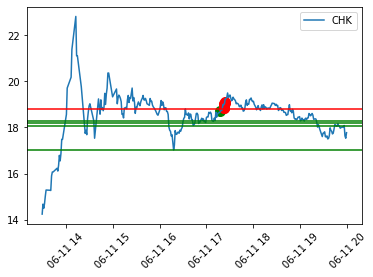

HUYA analysis for run 1474 with profit 33.95


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6173.04,-6173.04,buy,2020-06-11 17:04:10.871491,17.34,"[17.01, 17.12, 17.14]",[17.48],356,"{'avg': 16.9542, 'rsi': 66.75527973325278, 'macd': [0.02025234864299108, 0.02628081498172463, 0.03030561550373534, 0.03510788810071119, 0.03966684368978335], 'vwap': 17.3383, 'supports': [16.88, 17.0329, 17.12, 17.12, 17.14, 17.2], 'sell_macd': [0.011703314753702898, 0.015621050537561132, 0.01821122062190028, 0.021291726913311493, 0.02419482627137981], 'slow macd': [0.012194952172567497, 0.01385844469691122, 0.015286778371333298, 0.016976282038410062, 0.01874343230221953], 'macd_signal': [0.017508555571799367, 0.01926300745378442, 0.021471529063774603, 0.02419880087116192, 0.027292409434886207], 'resistances': [17.48], 'position_ratio': '1.0', 'sell_macd_signal': [0.010026157240209554, 0.01114513589967987, 0.012558352844123951, 0.01430502765796146, 0.01628298738064513]}",17.9,17.06
1,-3074.06,3098.98,sell,2020-06-11 17:13:04.398257,17.41,None,None,178,"{'avg': 16.9599, 'rsi': [65.12864611525787, 73.71675029749115], 'vwap': 17.407, 'reasons': 'scale-out', 'movement': 0.004596309111879988, 'sell_macd': [0.024597516857991053, 0.024133067958267418, 0.024236964036948194, 0.02418497443543899, 0.028048554298738537], 'sell_macd_signal': [0.021335639040218818, 0.02189512482382854, 0.02236349266645247, 0.022727789020249772, 0.023791942075947526]}",17.9,17.06
2,-1521.01,1553.05,sell,2020-06-11 17:15:17.087436,17.45,None,None,89,"{'avg': 16.9653, 'rsi': [74.16400833562402, 76.21964453940124], 'vwap': 17.4408, 'reasons': 'scale-out', 'movement': 0.0022975301550832365, 'sell_macd': [0.024236964036948194, 0.02418497443543899, 0.028048554298738537, 0.030970193746778563, 0.03414328690438495], 'sell_macd_signal': [0.02236349266645247, 0.022727789020249772, 0.023791942075947526, 0.025227592410113735, 0.02701073130896798]}",17.9,17.06
3,-752.77,768.24,sell,2020-06-11 17:15:59.760335,17.46,None,None,44,"{'avg': 16.9698, 'rsi': [75.9207704211167, 77.62160869666832], 'vwap': 17.468, 'reasons': 'scale-out', 'movement': 0.0010315186246418729, 'sell_macd': [0.02418497443543899, 0.028048554298738537, 0.030970193746778563, 0.033940689501786636, 0.036952235680992374], 'sell_macd_signal': [0.022727789020249772, 0.023791942075947526, 0.025227592410113735, 0.026970211828448314, 0.028966616598957128]}",17.9,17.06
4,-368.21,384.56,sell,2020-06-11 17:16:47.808916,17.48,None,None,22,"{'avg': 16.9704, 'rsi': [77.76503958053968, 78.50680977928327], 'vwap': 17.48, 'reasons': 'scale-out', 'movement': 0.0011454753722794715, 'sell_macd': [0.028048554298738537, 0.030970193746778563, 0.033940689501786636, 0.03705613178488676, 0.03952198120308381], 'sell_macd_signal': [0.023791942075947526, 0.025227592410113735, 0.026970211828448314, 0.028987395819736004, 0.031094312896405567]}",17.9,17.06
5,-175.93,192.28,sell,2020-06-11 17:16:51.784574,17.48,None,None,11,"{'avg': 16.9709, 'rsi': [77.76503958053968, 78.85943998655348], 'vwap': 17.4806, 'reasons': 'scale-out', 'movement': 0.0002860411899312932, 'sell_macd': [0.028048554298738537, 0.030970193746778563, 0.033940689501786636, 0.03705613178488676, 0.03978172146282333], 'sell_macd_signal': [0.023791942075947526, 0.025227592410113735, 0.026970211828448314, 0.028987395819736004, 0.031146260948353467]}",17.9,17.06
6,33.95,209.88,sell,2020-06-11 17:16:59.858823,17.49,None,None,12,"{'avg': 16.9751, 'rsi': [77.76503958053968, 79.85116186162567], 'vwap': 17.499, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.001144164759725376, 'sell_macd': [0.028048554298738537, 0.030970193746778563, 0.033940689501786636, 0.03705613178488676, 0.04056094224204543], 'sell_macd_signal': [0.023791942075947526, 0.025227592410113735, 0.026970211828448314, 0.028987395819736004, 0.03130210510419789]}",17.9,17.06


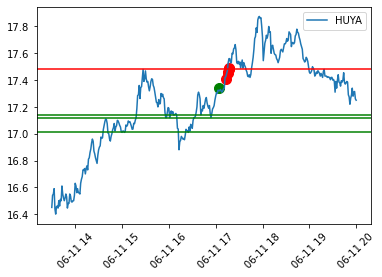

DXD analysis for run 1474 with profit -4183.91


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8413.19,-8413.19,buy,2020-06-11 16:45:38.159591,19.43,"[19.05, 19.25]","[19.69, 19.69, 19.725]",433,"{'avg': 18.8835, 'rsi': 67.83205950218128, 'macd': [0.02879481129556183, 0.030219685816234687, 0.035379121001192004, 0.03861937226004741, 0.04151564464507729], 'vwap': 19.43, 'supports': [18.86, 18.87, 18.92, 19.05, 19.25], 'sell_macd': [0.015559062362701326, 0.016558436628368867, 0.019979268048000876, 0.022125639699041244, 0.024030271638824985], 'slow macd': [0.0531412811305394, 0.053140871633196696, 0.053935151625232436, 0.054499684874002696, 0.05509184491635466], 'macd_signal': [0.027973792640680006, 0.028422971275790944, 0.029814201220871157, 0.03157523542870641, 0.033563317271980586], 'resistances': [19.725], 'position_ratio': '1.64', 'sell_macd_signal': [0.014717599644939206, 0.015085767041625137, 0.016064467242900286, 0.01727670173412848, 0.01862741571506778]}",19.89,19.2
1,-4183.91,4229.28,sell,2020-06-11 16:55:01.496114,19.58,None,None,216,"{'avg': 18.9131, 'rsi': [70.84358550486824, 75.55520370823248], 'vwap': 19.58, 'reasons': 'scale-out', 'movement': 0.007720020586721492, 'sell_macd': [0.029541577263469065, 0.031026536370376334, 0.03281966637094769, 0.034310161613326784, 0.03814288307994218], 'sell_macd_signal': [0.02314823067941178, 0.02472389181760469, 0.02634304672827329, 0.02793646970528399, 0.029977752380215626]}",19.89,19.2


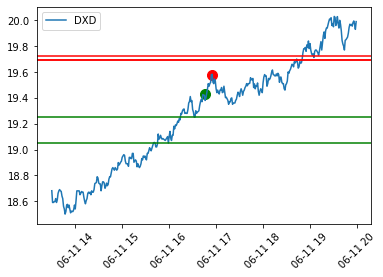

FAZ analysis for run 1474 with profit -94.86


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9738.96,-9738.96,buy,2020-06-11 16:27:03.732399,18.48,"[18.06, 18.1439, 18.17, 18.39]",[18.7202],527,"{'avg': 17.809, 'rsi': 67.11016285831117, 'macd': [0.04795249366383203, 0.04382082913788565, 0.042477549761283484, 0.04492965224672574, 0.047902329097180285], 'vwap': 18.4895, 'supports': [17.57, 17.9201, 17.945, 18.06, 18.1439, 18.17, 18.39], 'sell_macd': [0.027826412556791524, 0.025096428884122446, 0.024201682790039314, 0.025787573070104486, 0.027706610001711596], 'slow macd': [0.06917741771798092, 0.06828599338568964, 0.06783644865872418, 0.06811403833829743, 0.06857396544719307], 'macd_signal': [0.050289667412305464, 0.0489958997574215, 0.0476922297581939, 0.047139714255900265, 0.04729223722415627], 'resistances': [18.7202], 'position_ratio': '2.32', 'sell_macd_signal': [0.029548857797013956, 0.028658372014435655, 0.027767034169556386, 0.027371141949666007, 0.027438235560075123]}",18.87,18.3
1,-94.86,9644.10,sell,2020-06-11 16:31:37.973025,18.30,None,None,527,"{'avg': 17.8233, 'rsi': [45.765349560899885, 41.42079619907032], 'vwap': 18.3001, 'reasons': 'stopped', 'movement': -0.009740259740259724, 'sell_macd': [0.03147104610457774, 0.029304141777572568, 0.02775974695422434, 0.020481520508052853, 0.011946778855087103], 'sell_macd_signal': [0.02824812234430038, 0.028459326230954818, 0.02831941037560872, 0.026751832402097546, 0.023790821692695457]}",18.87,18.3


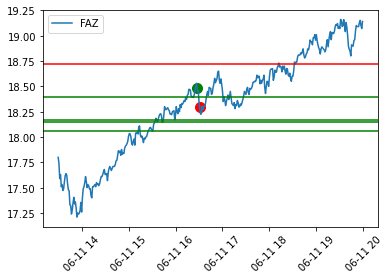

DRV analysis for run 1474 with profit -109.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9254.1,-9254.1,buy,2020-06-11 16:20:04.237797,16.98,"[16.7759, 16.8499]","[17.105, 17.12]",545,"{'avg': 16.5294, 'rsi': 61.962322535733094, 'macd': [0.007086290541092666, 0.008304939827908697, 0.00996279964147817, 0.01505698838839109, 0.020551785971999692], 'vwap': 16.9765, 'supports': [16.56, 16.7, 16.71, 16.7759, 16.785, 16.79, 16.8499], 'sell_macd': [0.003983313382899922, 0.004780258821579508, 0.0058586545033847415, 0.009168330950199532, 0.01271913946784764], 'slow macd': [0.03233417265185423, 0.031905429739296665, 0.03161988029476959, 0.032090280617428135, 0.03280760569538543], 'macd_signal': [0.00803153832656706, 0.008086218626835387, 0.008461534829763943, 0.009780625541489372, 0.011934857627591436], 'resistances': [17.105, 17.12], 'position_ratio': '0.96', 'sell_macd_signal': [0.00458112575959998, 0.004620952371995886, 0.004868492798273657, 0.005728460428658832, 0.007126596236496594]}",17.35,16.8
1,-109.0,9145.1,sell,2020-06-11 16:31:17.332677,16.78,None,None,545,"{'avg': 16.5494, 'rsi': [48.7708239609605, 35.543630804268574], 'vwap': 16.7826, 'reasons': 'stopped', 'movement': -0.011778563015312089, 'sell_macd': [0.018833958735918088, 0.018336834955654524, 0.0179606757118691, 0.01432781557759455, 0.004038212673258101], 'sell_macd_signal': [0.01403599721699376, 0.014896164764725913, 0.01550906695415455, 0.01527281667884255, 0.01302589587772566]}",17.35,16.8


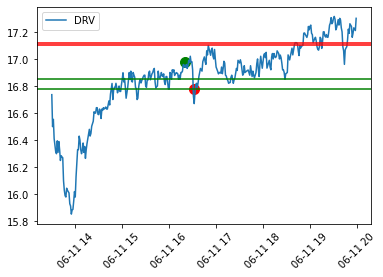

BZQ analysis for run 1474 with profit -3350.16


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3350.16,-3350.16,buy,2020-06-11 16:28:13.541,17.82,"[17.18, 17.26, 17.35, 17.43]","[19.16, 19.16, 19.17, 19.17, 19.28]",188,"{'avg': 17.1311, 'rsi': 67.99532792944044, 'macd': [0.06544295176715309, 0.06898245191783658, 0.0669728585667464, 0.06783402778094327, 0.07092657884299314], 'vwap': 17.82, 'supports': [16.87, 17.18, 17.26, 17.27, 17.35, 17.43], 'sell_macd': [0.03867193480015274, 0.040881438234574574, 0.03946960405055577, 0.0399399981402766, 0.041865759792781176], 'slow macd': [0.07036631210892352, 0.07163422854571877, 0.0718849037983702, 0.07264190665369341, 0.07386193701893617], 'macd_signal': [0.06339302908203295, 0.06451091364919367, 0.06500330263270422, 0.06556944766235204, 0.06664087389848025], 'resistances': [19.16, 19.16, 19.17, 19.17], 'position_ratio': '3.44', 'sell_macd_signal': [0.037750363602050724, 0.03837657852855549, 0.03859518363295555, 0.03886414653441976, 0.03946446918609205]}",18.88,17.29


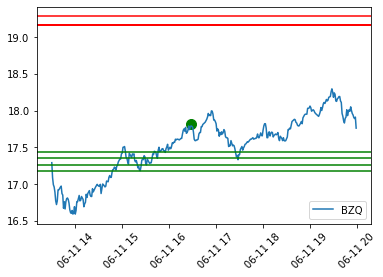

SOXS analysis for run 1475 with profit 60.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4808.22,-4808.22,buy,2020-06-11 18:35:22.456246,6.31,[6.236],[6.31],762,"{'avg': 6.0575, 'rsi': 63.46400695895847, 'macd': [0.005238218587201082, 0.007968575249761578, 0.009610095993935808, 0.011807753602687932, 0.013722069351964628], 'vwap': 6.3141, 'supports': [6.101, 6.15, 6.16, 6.2088, 6.236], 'sell_macd': [0.0021098699757837736, 0.003939003380575734, 0.005048211184562668, 0.006511902834622774, 0.007780858629025111], 'slow macd': [0.016696154426843357, 0.01704419073076746, 0.017255568088786255, 0.017627162262495943, 0.018006422376312337], 'macd_signal': [0.010573960392783759, 0.010052883364179322, 0.00996432589013062, 0.010333011432642081, 0.01101082301650659], 'resistances': [6.85], 'position_ratio': '6.86', 'sell_macd_signal': [0.00550996111808685, 0.005195769570584627, 0.005166257893380235, 0.005435386881628743, 0.005904481231108016]}",6.58,6.18
1,-2358.39,2449.83,sell,2020-06-11 18:58:37.854093,6.43,None,None,381,"{'avg': 6.0872, 'rsi': [61.510716365776254, 69.26989825085664], 'vwap': 6.4388, 'reasons': 'scale-out', 'movement': 0.020412044374009515, 'sell_macd': [0.01748316624222568, 0.016531481668726755, 0.01579859133004291, 0.014861292477431398, 0.015891172689975974], 'sell_macd_signal': [0.01696493227668793, 0.016878242155095695, 0.016662311990085138, 0.01630210808755439, 0.016219921008038707]}",6.58,6.18
2,60.96,2419.35,sell,2020-06-11 19:45:06.555144,6.35,None,None,381,{'liquidation': 1},6.58,6.18


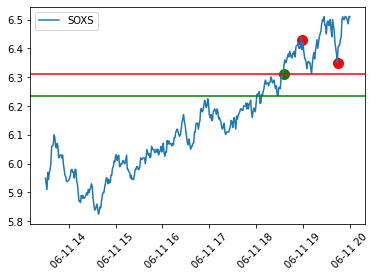

DXD analysis for run 1475 with profit 53.19


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4216.31,-4216.31,buy,2020-06-11 17:48:52.469210,19.43,"[19.3499, 19.43]",[19.5558],217,"{'avg': 18.8835, 'rsi': 67.83205950218128, 'macd': [0.02879481129556183, 0.030219685816234687, 0.035379121001192004, 0.03861937226004741, 0.04151564464507729], 'vwap': 19.43, 'supports': [18.86, 18.87, 18.92, 19.05, 19.25], 'sell_macd': [0.015559062362701326, 0.016558436628368867, 0.019979268048000876, 0.022125639699041244, 0.024030271638824985], 'slow macd': [0.0531412811305394, 0.053140871633196696, 0.053935151625232436, 0.054499684874002696, 0.05509184491635466], 'macd_signal': [0.027973792640680006, 0.028422971275790944, 0.029814201220871157, 0.03157523542870641, 0.033563317271980586], 'resistances': [19.725], 'position_ratio': '1.64', 'sell_macd_signal': [0.014717599644939206, 0.015085767041625137, 0.016064467242900286, 0.01727670173412848, 0.01862741571506778]}",19.89,19.20
1,17.36,4233.67,sell,2020-06-11 17:49:07.048495,19.51,None,None,217,"{'avg': 19.0366, 'rsi': [50.286743764566275, 55.24566542321598], 'vwap': 19.5039, 'reasons': 'bail', 'movement': 0.004117344312918263, 'sell_macd': [0.019781939074675847, 0.020205241869884816, 0.02079216298472275, 0.017343112386097204, 0.01598874682371232], 'sell_macd_signal': [0.014407826760315694, 0.015567309782229519, 0.016612280422728165, 0.01675844681540197, 0.01660450681706404]}",19.89,19.20
2,-4978.09,-4995.45,buy,2020-06-11 18:11:13.867813,19.59,"[19.42, 19.49]","[19.69, 19.69, 19.725]",255,"{'avg': 19.0615, 'rsi': 60.81613934547712, 'macd': [0.017272256058234348, 0.01749989444895661, 0.018276535416628548, 0.020272176796812147, 0.02320013312833069], 'vwap': 19.59, 'supports': [19.25, 19.3499, 19.42, 19.43, 19.49], 'sell_macd': [0.010233898224736748, 0.010363431975889625, 0.010849257860222394, 0.012125885070606301, 0.014002141532323265], 'slow macd': [0.022096781394289167, 0.02217921968706449, 0.022379529016504307, 0.022847899128848326, 0.02356214464343509], 'macd_signal': [0.01437575118617932, 0.015000579838734778, 0.01565577095431353, 0.016579052122813253, 0.01790326832391674], 'resistances': [19.69, 19.69, 19.725], 'position_ratio': '1.0', 'sell_macd_signal': [0.00834869010339032, 0.008751638477890181, 0.009171162354356624, 0.00976210689760656, 0.010610113824549901]}",20.03,19.37
3,-5095.63,-117.54,buy,2020-06-11 18:11:14.256354,19.59,"[19.42, 19.49]","[19.69, 19.69, 19.725]",6,"{'avg': 19.0615, 'rsi': 60.81613934547712, 'macd': [0.017272256058234348, 0.01749989444895661, 0.018276535416628548, 0.020272176796812147, 0.02320013312833069], 'vwap': 19.59, 'supports': [19.25, 19.3499, 19.42, 19.43, 19.49], 'sell_macd': [0.010233898224736748, 0.010363431975889625, 0.010849257860222394, 0.012125885070606301, 0.014002141532323265], 'slow macd': [0.022096781394289167, 0.02217921968706449, 0.022379529016504307, 0.022847899128848326, 0.02356214464343509], 'macd_signal': [0.01437575118617932, 0.015000579838734778, 0.01565577095431353, 0.016579052122813253, 0.01790326832391674], 'resistances': [19.69, 19.69, 19.725], 'position_ratio': '1.0', 'sell_macd_signal': [0.00834869010339032, 0.008751638477890181, 0.009171162354356624, 0.00976210689760656, 0.010610113824549901]}",20.03,19.37
4,-8876.50,-3780.87,buy,2020-06-11 18:11:14.593514,19.59,"[19.42, 19.49]","[19.69, 19.69, 19.725]",193,"{'avg': 19.0615, 'rsi': 60.81613934547712, 'macd': [0.017272256058234348, 0.01749989444895661, 0.018276535416628548, 0.020272176796812147, 0.02320013312833069], 'vwap': 19.59, 'supports': [19.25, 19.3499, 19.42, 19.43, 19.49], 'sell_macd': [0.010233898224736748, 0.010363431975889625, 0.010849257860222394, 0.012125885070606301, 0.014002141532323265], 'slow macd': [0.022096781394289167, 0.02217921968706449, 0.022379529016504307, 0.022847899128848326, 0.02356214464343509], 'macd_signal': [0.01437575118617932, 0.015000579838734778, 0.01565577095431353, 0.016579052122813253, 0.01790326832391674], 'resistances': [19.69, 19.69, 19.725]

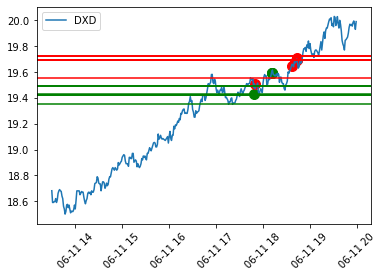

DRV analysis for run 1475 with profit 13.27


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7116.66,-7116.66,buy,2020-06-11 18:55:48.753397,17.19,"[16.85, 16.92, 17.025]",[17.35],414,"{'avg': 16.6565, 'rsi': 64.50745922946238, 'macd': [0.029768185882012688, 0.030159147793742846, 0.030121762991896617, 0.03692869213014305, 0.04200843784095909], 'vwap': 17.1941, 'supports': [16.82, 16.85, 16.86, 16.87, 16.88, 16.89, 16.92, 17.025], 'sell_macd': [0.01817507646859795, 0.018348627831002773, 0.018245568790916877, 0.022603632281875008, 0.025815063154286833], 'slow macd': [0.019420778819014828, 0.02008880316013517, 0.02067127768883381, 0.02261353629730678, 0.024397895718699658], 'macd_signal': [0.026786282196041584, 0.027460855315581838, 0.027993036850844793, 0.029780167906704444, 0.03222582189355537], 'resistances': [17.35], 'position_ratio': '0.94', 'sell_macd_signal': [0.01650365817927999, 0.016872652109624547, 0.017147235445883015, 0.018238514813081412, 0.019753824481322495]}",17.68,16.95
1,-3537.63,3579.03,sell,2020-06-11 19:27:53.463094,17.29,None,None,207,"{'avg': 16.6969, 'rsi': [63.34996798452555, 66.22970953015752], 'vwap': 17.2959, 'reasons': 'scale-out', 'movement': 0.006282722513088829, 'sell_macd': [0.007167594925501675, 0.008807638204427093, 0.012568611691843756, 0.01611523243929014, 0.020383830003023462], 'sell_macd_signal': [0.006471615961243964, 0.00693882040988059, 0.008064778666273222, 0.009674869420876605, 0.011816661537305977]}",17.68,16.95
2,-1751.61,1786.02,sell,2020-06-11 19:30:35.377615,17.34,None,None,103,"{'avg': 16.7004, 'rsi': [60.929284777861334, 66.87540224620648], 'vwap': 17.3332, 'reasons': 'scale-out', 'movement': 0.002891844997108196, 'sell_macd': [0.01611523243929014, 0.020747466366660916, 0.021749889344263806, 0.022768012582080388, 0.026902030526066767], 'sell_macd_signal': [0.009674869420876605, 0.011889388810033468, 0.013861488916879536, 0.015642793649919707, 0.017894641025149118]}",17.68,16.95
3,13.27,1764.88,sell,2020-06-11 19:45:08.562473,16.97,None,None,104,{'liquidation': 1},17.68,16.95


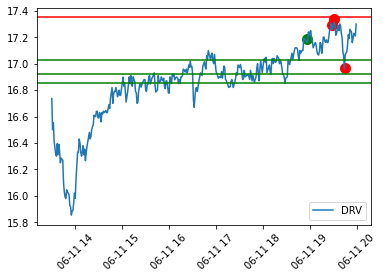

BZQ analysis for run 1475 with profit 41.36


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3350.16,-3350.16,buy,2020-06-11 17:48:52.676944,17.82,[17.33],[17.995],188,"{'avg': 17.1311, 'rsi': 67.99532792944044, 'macd': [0.06544295176715309, 0.06898245191783658, 0.0669728585667464, 0.06783402778094327, 0.07092657884299314], 'vwap': 17.82, 'supports': [16.87, 17.18, 17.26, 17.27, 17.35, 17.43], 'sell_macd': [0.03867193480015274, 0.040881438234574574, 0.03946960405055577, 0.0399399981402766, 0.041865759792781176], 'slow macd': [0.07036631210892352, 0.07163422854571877, 0.0718849037983702, 0.07264190665369341, 0.07386193701893617], 'macd_signal': [0.06339302908203295, 0.06451091364919367, 0.06500330263270422, 0.06556944766235204, 0.06664087389848025], 'resistances': [19.16, 19.16, 19.17, 19.17], 'position_ratio': '3.44', 'sell_macd_signal': [0.037750363602050724, 0.03837657852855549, 0.03859518363295555, 0.03886414653441976, 0.03946446918609205]}",18.88,17.29
1,-734.36,2615.80,sell,2020-06-11 18:58:43.033791,18.04,None,None,145,"{'avg': 17.3806, 'rsi': [77.34487505985891, 79.21338453721923], 'vwap': 18.06, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.01346801346801338, 'sell_macd': [0.0320201232776256, 0.03344779653110308, 0.034125882228213555, 0.03836691157365024, 0.04273177974446085], 'sell_macd_signal': [0.027103645786991946, 0.028372475935814174, 0.02952315719429405, 0.03129190807016529, 0.0335798824050244]}",18.88,17.29
2,41.36,775.72,sell,2020-06-11 18:58:43.270481,18.04,None,None,43,"{'avg': 17.3806, 'rsi': [77.34487505985891, 79.21338453721923], 'vwap': 18.06, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.01346801346801338, 'sell_macd': [0.0320201232776256, 0.03344779653110308, 0.034125882228213555, 0.03836691157365024, 0.04273177974446085], 'sell_macd_signal': [0.027103645786991946, 0.028372475935814174, 0.02952315719429405, 0.03129190807016529, 0.0335798824050244]}",18.88,17.29


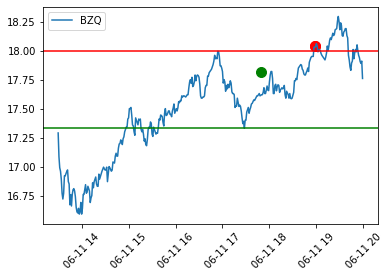

SRS analysis for run 1475 with profit 56.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-13919.45,-13919.45,buy,2020-06-11 18:51:35.198225,16.67,"[16.51, 16.52, 16.6]","[16.76, 16.945]",835,"{'avg': 16.3245, 'rsi': 62.51278355441669, 'macd': [0.02026339313018255, 0.019533885299512832, 0.018907246568367952, 0.01962874332808795, 0.021565770779968574], 'vwap': 16.67, 'supports': [16.43, 16.4701, 16.471, 16.51, 16.52, 16.6], 'sell_macd': [0.012331763227511061, 0.011803967546985206, 0.011348490814796719, 0.011776061012898964, 0.012995257777486557], 'slow macd': [0.013759490788832096, 0.014001593409055602, 0.014235528537202669, 0.014714274085271484, 0.015451073929241943], 'macd_signal': [0.01848021023216019, 0.018690945245630718, 0.018734205510178164, 0.018913113073760122, 0.019443644615001813], 'resistances': [16.76, 16.945, 16.99], 'position_ratio': '1.29', 'sell_macd_signal': [0.011348200890753678, 0.011439354221999983, 0.01142118154055933, 0.011492157435027257, 0.011792777503519116]}",16.91,16.55
1,-6947.21,6972.24,sell,2020-06-11 18:55:57.390103,16.72,None,None,417,"{'avg': 16.3289, 'rsi': [66.66865555638802, 69.35909999818347], 'vwap': 16.72, 'reasons': 'scale-out', 'movement': 0.002999400119975834, 'sell_macd': [0.011776061012898964, 0.013514738296969142, 0.015732996722256587, 0.017257185148167764, 0.019259706192407577], 'sell_macd_signal': [0.011492157435027257, 0.011896673607415633, 0.012663938230383824, 0.013582587613940612, 0.014718011329634005]}",16.91,16.55
2,-3448.55,3498.66,sell,2020-06-11 19:25:55.993232,16.74,None,None,209,"{'avg': 16.3613, 'rsi': [58.57447932009514, 66.11769601719942], 'vwap': 16.741, 'reasons': 'scale-out', 'movement': 0.0014952153110049122, 'sell_macd': [0.0008811898042964117, 0.0016433955026080582, 0.002636758442815079, 0.003979161273591103, 0.007228057488823936], 'sell_macd_signal': [0.00016862378586776473, 0.00046357812921582345, 0.0008982141919356746, 0.0015144036082667604, 0.0026571343843781953]}",16.91,16.55
3,-1705.51,1743.04,sell,2020-06-11 19:27:00.603748,16.76,None,None,104,"{'avg': 16.3616, 'rsi': [58.57447932009514, 68.12381408324002], 'vwap': 16.7592, 'reasons': 'scale-out', 'movement': 0.001194743130227188, 'sell_macd': [0.0008811898042964117, 0.0016433955026080582, 0.002636758442815079, 0.003979161273591103, 0.008007278268046036], 'sell_macd_signal': [0.00016862378586776473, 0.00046357812921582345, 0.0008982141919356746, 0.0015144036082667604, 0.0028129785402226156]}",16.91,16.55
4,-832.95,872.56,sell,2020-06-11 19:27:14.978110,16.78,None,None,52,"{'avg': 16.3624, 'rsi': [68.12381408324, 69.51918060752197], 'vwap': 16.77, 'reasons': 'scale-out', 'movement': 0.000596658711217065, 'sell_macd': [0.002636758442815079, 0.003979161273591103, 0.008007278268046036, 0.011042080104399332, 0.013782937637863313], 'sell_macd_signal': [0.0008982141919356746, 0.0015144036082667604, 0.0028129785402226156, 0.004458798853057959, 0.00632362661001903]}",16.91,16.55
5,-396.67,436.28,sell,2020-06-11 19:27:49.168037,16.78,None,None,26,"{'avg': 16.3628, 'rsi': [68.12381408324, 70.79750734290143], 'vwap': 16.78, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.002636758442815079, 0.003979161273591103, 0.008007278268046036, 0.011042080104399332, 0.014302418157345897], 'sell_macd_signal': [0.0008982141919356746, 0.0015144036082667604, 0.0028129785402226156, 0.004458798853057959, 0.006427522713915547]}",16.91,16.55
6,-262.35,134.32,sell,2020-06-11 19:27:53.797060,16.79,None,None,8,"{'avg': 16.363, 'rsi': [68.12381408324, 70.79750734290143], 'vwap': 16.78, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.002636758442815079, 0.003979161273591103, 0.008007278268046036, 0.011042080104399332, 0.014302418157345897], 'sell_macd_signal': [0.0008982141919356746, 0.0015144036082667604, 0.0028129785402226156, 0.004458798853057959, 0.006427522713915547]}",16.91,16.55
7,-178.40,83.95,sell,2020-06-11 19:27:53.974442,16.79,None,None,5,"{'avg': 16.363, 'rsi': [68.12381408324, 70.79750734290143], 'vwap': 

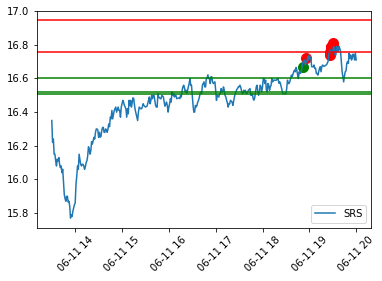

SQQQ analysis for run 1475 with profit 76.34


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4541.44,-4541.44,buy,2020-06-11 18:11:39.677076,8.87,"[8.6766, 8.735, 8.78]","[9.2642, 9.2999]",512,"{'avg': 8.4912, 'rsi': 64.03819325921434, 'macd': [0.013668105763064986, 0.01451651450317648, 0.015949125174167023, 0.017823117863128957, 0.02094692275775145], 'vwap': 8.875, 'supports': [8.6004, 8.6766, 8.735, 8.745, 8.78], 'sell_macd': [0.008020148577069008, 0.008559907423752122, 0.00947712331176831, 0.010676549675006086, 0.012682900741488368], 'slow macd': [0.017174147593417288, 0.017389510564752797, 0.0177469644451147, 0.018234574809341098, 0.01902667922711565], 'macd_signal': [0.012407469896077414, 0.012829278817497227, 0.013453248088831186, 0.01432722204369074, 0.015651162186502882], 'resistances': [9.2642, 9.27, 9.2999], 'position_ratio': '4.1', 'sell_macd_signal': [0.007231827490222207, 0.00749744347692819, 0.007893379443896214, 0.008450013490118188, 0.009296590940392225]}",9.27,8.68
1,51.20,4592.64,sell,2020-06-11 18:49:10.861559,8.97,None,None,512,"{'avg': 8.5278, 'rsi': [66.42770622640597, 62.96356161518114], 'vwap': 8.9701, 'reasons': 'bail', 'movement': 0.011273957158962957, 'sell_macd': [0.018832477079014254, 0.018014492889406597, 0.017813278028812718, 0.01780956153966251, 0.017087060878770544], 'sell_macd_signal': [0.0167863486222833, 0.01703197747570796, 0.01718823758632891, 0.01731250237699563, 0.017267414077350614]}",9.27,8.68
2,-3715.61,-3766.81,buy,2020-06-11 18:50:51.790749,8.99,"[8.8185, 8.949]","[9.2642, 9.2999]",419,"{'avg': 8.5314, 'rsi': 69.93130505229189, 'macd': [0.03013141825494081, 0.02990880877589497, 0.02998387190455354, 0.030945429946612535, 0.03166522123373383], 'vwap': 8.9989, 'supports': [8.6766, 8.735, 8.745, 8.78, 8.8185, 8.949], 'sell_macd': [0.018014492889406597, 0.017813278028812718, 0.01780956153966251, 0.018385762177471676, 0.018803765763070857], 'slow macd': [0.02702241342017686, 0.02738666745366558, 0.02779634432741318, 0.028378303987222964, 0.028932312768219504], 'macd_signal': [0.028321785284533958, 0.02863918998280616, 0.028908126367155635, 0.029315587083047014, 0.02978551391318438], 'resistances': [9.2642, 9.2999, 9.32], 'position_ratio': '5.3', 'sell_macd_signal': [0.01703197747570796, 0.01718823758632891, 0.01731250237699563, 0.017527154337090838, 0.017782476622286842]}",9.48,8.76
3,76.34,3791.95,sell,2020-06-11 19:31:19.752278,9.05,None,None,419,"{'avg': 8.5989, 'rsi': [52.97265665872523, 56.1161438917163], 'vwap': 9.0599, 'reasons': 'bail', 'movement': 0.007786429365962212, 'sell_macd': [0.022325704661131596, 0.021149319734506733, 0.020217729925001038, 0.0176708063081783, 0.016495660550807756], 'sell_macd_signal': [0.014911241260203583, 0.016158856955064214, 0.01697063154905158, 0.017110666500876923, 0.01698766531086309]}",9.48,8.76


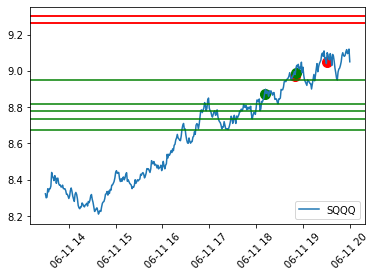

QID analysis for run 1475 with profit 58.32


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6823.44,-6823.44,buy,2020-06-11 18:11:39.073763,14.04,"[13.89, 13.9296, 13.9486]","[14.42, 14.46, 14.46, 14.4798]",486,"{'avg': 13.6018, 'rsi': 63.99733171351015, 'macd': [0.016116629497179957, 0.01676798670088253, 0.018682662724284427, 0.020767577982228502, 0.02379971867740238], 'vwap': 14.0405, 'supports': [13.745, 13.8207, 13.89, 13.895, 13.9486], 'sell_macd': [0.00956203734853922, 0.009964798707443379, 0.011188186796101007, 0.012515655608092757, 0.01445244097317655], 'slow macd': [0.018651071560709553, 0.018873936615454667, 0.019368665421733766, 0.01995279030040642, 0.020786161025966976], 'macd_signal': [0.014043148652856833, 0.014588116262461972, 0.015407025554826464, 0.01647913604030687, 0.017943252567725974], 'resistances': [14.42, 14.46], 'position_ratio': '4.13', 'sell_macd_signal': [0.008265009159486731, 0.00860496706907806, 0.00912161101448265, 0.009800419933204671, 0.010730824141199047]}",14.45,13.83
1,58.32,6881.76,sell,2020-06-11 18:51:05.909793,14.16,None,None,486,"{'avg': 13.6321, 'rsi': [66.25938355333443, 62.66942325099437], 'vwap': 14.15, 'reasons': 'bail', 'movement': 0.007834757834757922, 'sell_macd': [0.019033897987764448, 0.019356818230052752, 0.01935705714313407, 0.01910585295666145, 0.018142500954779095], 'sell_macd_signal': [0.018135577538499682, 0.018379825676810298, 0.018575271970075052, 0.018681388167392333, 0.018573610724869686]}",14.45,13.83


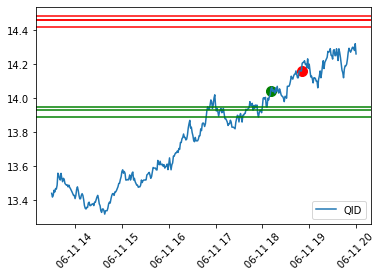

PSQ analysis for run 1475 with profit 46.62


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-13293.36,-13293.36,buy,2020-06-11 18:12:11.207225,19.96,[19.86],"[20.22, 20.24]",666,"{'avg': 19.6905, 'rsi': 62.32330804985137, 'macd': [0.011137950738298485, 0.011708508977147147, 0.01281981803633414, 0.01354440697972592, 0.015553194248994373], 'vwap': 19.96, 'supports': [19.75, 19.81, 19.86, 19.865], 'sell_macd': [0.006555179197633265, 0.006913768322192482, 0.007622879739741961, 0.008076435652899505, 0.009363928109220154], 'slow macd': [0.013937063409393602, 0.0140887495362918, 0.014365708664580978, 0.014597543978268845, 0.015107365202130296], 'macd_signal': [0.010507500827996457, 0.010747702457826596, 0.011162125573528105, 0.011638581854767668, 0.012421504333613009], 'resistances': [20.22, 20.22, 20.24], 'position_ratio': '2.74', 'sell_macd_signal': [0.00618736539715158, 0.00633264598215976, 0.0065906927336762, 0.006887841317520861, 0.0073830586758607195]}",20.26,19.81
1,46.62,13339.98,sell,2020-06-11 18:47:05.910997,20.03,None,None,666,"{'avg': 19.7106, 'rsi': [60.22926476655469, 60.22926476655468], 'vwap': 20.03, 'reasons': 'bail', 'movement': 0.003507014028056126, 'sell_macd': [0.015995978322550286, 0.016148246185974102, 0.015018217947261547, 0.013942634671028742, 0.012923444654862948], 'sell_macd_signal': [0.012224316131577203, 0.013009102142456583, 0.013410925303417576, 0.01351726717693981, 0.013398502672524437]}",20.26,19.81


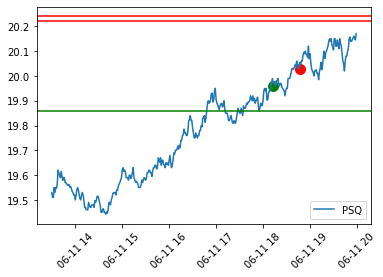

UGAZ analysis for run 1475 with profit 18.16


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6306.06,-6306.06,buy,2020-06-11 18:05:37.500358,13.89,"[13.6411, 13.725]",[14.095],454,"{'avg': 13.5526, 'rsi': 64.22155894481692, 'macd': [0.007543236758142058, 0.004128147207257626, 0.010180391608049177, 0.017598185464986926, 0.023608158595465056], 'vwap': 13.89, 'supports': [13.43, 13.5301, 13.6411, 13.725], 'sell_macd': [0.001877968823873033, -0.00021724104433396008, 0.003867234916080875, 0.008817901444766463, 0.012820785734069418], 'slow macd': [0.029899576176946496, 0.028853139082576362, 0.029603533200738497, 0.0308063491675874, 0.03194367589411584], 'macd_signal': [0.02638083399257193, 0.02193029663550907, 0.01958031563001709, 0.019183889597011058, 0.02006874339670186], 'resistances': [14.095], 'position_ratio': '1.24', 'sell_macd_signal': [0.014065439189060835, 0.011208903142381876, 0.009740569497121676, 0.009556035886650634, 0.010208985856134391]}",14.33,13.67
1,18.16,6324.22,sell,2020-06-11 19:45:07.026662,13.93,None,None,454,{'liquidation': 1},14.33,13.67


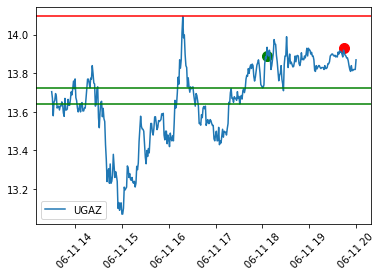

DRV analysis for run 1470 with profit -7241.92


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7241.92,-7241.92,buy,2020-06-11 16:05:15.877633,16.96,"[16.7, 16.71, 16.75, 16.785, 16.79]","[17.105, 17.12]",427,"{'avg': 16.5125, 'rsi': 59.64180300898536, 'macd': [-0.0049503197098701435, -0.0007520073569367014, -0.0006450446034165225, 0.005030154643396401, 0.01261009531091517], 'vwap': 16.95, 'supports': [16.2656, 16.56, 16.7, 16.71, 16.7759, 16.7797, 16.7984], 'sell_macd': [-0.00410578421366381, -0.001292421499577756, -0.0011613281963995803, 0.002592268250182883, 0.007561404854662612], 'slow macd': [0.04189700612619518, 0.04137548962300741, 0.04018975934219071, 0.040154123830983934, 0.040696861213387336], 'macd_signal': [0.0022697297153480085, 0.0016653823008910664, 0.0012032969200295486, 0.001968668464702919, 0.00409695383394537], 'resistances': [17.12, 17.135], 'position_ratio': '0.99', 'sell_macd_signal': [0.00036834990257594434, 3.619562214520421e-05, -0.0002033091415637527, 0.00035580633678557443, 0.001796926040360982]}",17.43,16.73


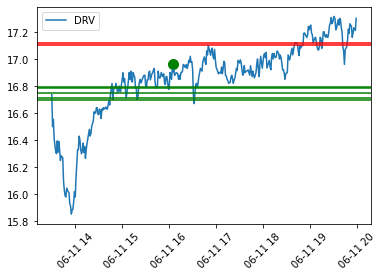

DRV analysis for run 1472 with profit -7241.92


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7241.92,-7241.92,buy,2020-06-11 16:12:07.488499,16.96,[16.7759],"[17.105, 17.12]",427,"{'avg': 16.5125, 'rsi': 59.64180300898536, 'macd': [-0.0049503197098701435, -0.0007520073569367014, -0.0006450446034165225, 0.005030154643396401, 0.01261009531091517], 'vwap': 16.95, 'supports': [16.2656, 16.56, 16.7, 16.71, 16.7759, 16.7797, 16.7984], 'sell_macd': [-0.00410578421366381, -0.001292421499577756, -0.0011613281963995803, 0.002592268250182883, 0.007561404854662612], 'slow macd': [0.04189700612619518, 0.04137548962300741, 0.04018975934219071, 0.040154123830983934, 0.040696861213387336], 'macd_signal': [0.0022697297153480085, 0.0016653823008910664, 0.0012032969200295486, 0.001968668464702919, 0.00409695383394537], 'resistances': [17.12, 17.135], 'position_ratio': '0.99', 'sell_macd_signal': [0.00036834990257594434, 3.619562214520421e-05, -0.0002033091415637527, 0.00035580633678557443, 0.001796926040360982]}",17.43,16.73


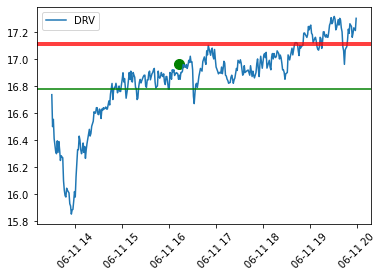

DRV analysis for run 1473 with profit -38.43


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7241.92,-7241.92,buy,2020-06-11 16:15:08.413028,16.96,[16.7759],"[17.105, 17.12]",427,"{'avg': 16.5125, 'rsi': 59.64180300898536, 'macd': [-0.0049503197098701435, -0.0007520073569367014, -0.0006450446034165225, 0.005030154643396401, 0.01261009531091517], 'vwap': 16.95, 'supports': [16.2656, 16.56, 16.7, 16.71, 16.7759, 16.7797, 16.7984], 'sell_macd': [-0.00410578421366381, -0.001292421499577756, -0.0011613281963995803, 0.002592268250182883, 0.007561404854662612], 'slow macd': [0.04189700612619518, 0.04137548962300741, 0.04018975934219071, 0.040154123830983934, 0.040696861213387336], 'macd_signal': [0.0022697297153480085, 0.0016653823008910664, 0.0012032969200295486, 0.001968668464702919, 0.00409695383394537], 'resistances': [17.12, 17.135], 'position_ratio': '0.99', 'sell_macd_signal': [0.00036834990257594434, 3.619562214520421e-05, -0.0002033091415637527, 0.00035580633678557443, 0.001796926040360982]}",17.43,16.73
1,-38.43,7203.49,sell,2020-06-11 16:15:20.033941,16.87,None,None,427,"{'avg': 16.5232, 'rsi': [67.74499513930877, 95.39943330338535], 'vwap': 16.8781, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': -0.004775943396226386, 'sell_macd': [0.020474736542153593, 0.020824764726647516, 0.023424465068766054, 0.027223913840952463, 0.15341538153562873], 'sell_macd_signal': [0.019635988842069626, 0.019873744018985205, 0.020583888228941374, 0.02191189335134359, 0.04821259098820062]}",17.43,16.73


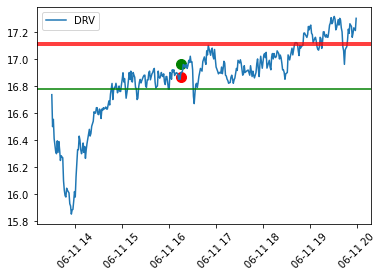

THMO analysis for run 1465 with profit -2318.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2318.68,-2318.68,buy,2020-06-11 14:44:46.264828,6.37,"[6.01, 6.1142, 6.15]","[6.5992, 6.61, 6.61]",364,"{'avg': 6.233, 'rsi': 65.65705484441536, 'macd': [0.030648483104672053, 0.030348366086815126, 0.03932407650203462, 0.044328703448409, 0.04973883905085685], 'vwap': 6.375, 'supports': [5.9452, 6.01, 6.1142, 6.15], 'sell_macd': [0.01852044189655011, 0.018271377835116454, 0.02406338794523233, 0.027235559616163307, 0.03065237442966584], 'slow macd': [0.03116752971948067, 0.03139836599846735, 0.03347655904682956, 0.0350183487181992, 0.03678067764220838], 'macd_signal': [0.02270354448750481, 0.024232508807366875, 0.027250822346300423, 0.03066639856672214, 0.03448088666354908], 'resistances': [6.5992, 6.61, 6.61], 'position_ratio': '1.0', 'sell_macd_signal': [0.013394760191313216, 0.014370083720073864, 0.016308744565105556, 0.018494107575317106, 0.020925760946186853]}",6.92,6.1


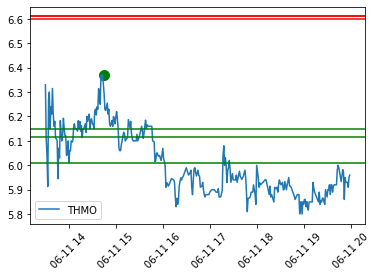

THMO analysis for run 1466 with profit -112.84


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2318.68,-2318.68,buy,2020-06-11 15:05:28.990320,6.37,"[6.01, 6.1142, 6.15]",[6.37],364,"{'avg': 6.233, 'rsi': 65.65705484441536, 'macd': [0.030648483104672053, 0.030348366086815126, 0.03932407650203462, 0.044328703448409, 0.04973883905085685], 'vwap': 6.375, 'supports': [5.9452, 6.01, 6.1142, 6.15], 'sell_macd': [0.01852044189655011, 0.018271377835116454, 0.02406338794523233, 0.027235559616163307, 0.03065237442966584], 'slow macd': [0.03116752971948067, 0.03139836599846735, 0.03347655904682956, 0.0350183487181992, 0.03678067764220838], 'macd_signal': [0.02270354448750481, 0.024232508807366875, 0.027250822346300423, 0.03066639856672214, 0.03448088666354908], 'resistances': [6.5992, 6.61, 6.61], 'position_ratio': '1.0', 'sell_macd_signal': [0.013394760191313216, 0.014370083720073864, 0.016308744565105556, 0.018494107575317106, 0.020925760946186853]}",6.92,6.1
1,-112.84,2205.84,sell,2020-06-11 15:06:05.151711,6.06,None,None,364,"{'avg': 6.2313, 'rsi': [35.46397151677576, 34.666352547650334], 'vwap': 6.0601, 'reasons': 'stopped', 'movement': -0.04864992150706434, 'sell_macd': [-0.006807377098270173, -0.006861402093889524, -0.008892312452893236, -0.014515199583897243, -0.019222446704369567], 'sell_macd_signal': [-0.004698191762462592, -0.005130833828747979, -0.0058831295535770305, -0.007609543559641073, -0.009932124188586772]}",6.92,6.1


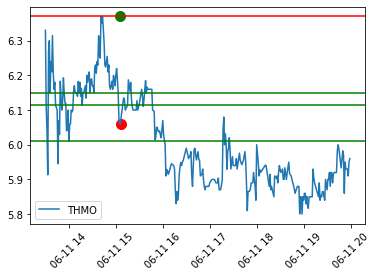

In [14]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        for symbol in minute_history:    
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()

In [15]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

Timestamp('2020-04-16 13:44:06.066000')

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))